# Proyecto Diplomado

## Parte 1: clasificación no supervisada

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import bigrams, trigrams, ngrams


stoplist = stopwords.words('spanish')

import pandas as pd
import numpy as np
import gensim
import seaborn as sns

from contexto.limpieza import limpieza_basica, limpieza_texto, lista_apellidos, lista_geo_colombia,lista_nombres,lista_stopwords
from contexto.exploracion import frecuencia_ngramas, grafica_barchart_frecuencias, grafica_nube, graficar_coocurrencias, matriz_coocurrencias, nube_palabras, obtener_ngramas, par_nubes
from contexto.lematizacion import lematizar_texto
from contexto.stemming import stem_texto
from contexto.vectorizacion import VectorizadorFrecuencias

In [2]:
dataframes = []
for numero in range(17,29):
    try:
        dataframes.append(pd.read_csv(f'2021-04-{numero}.csv').drop(columns='Unnamed: 0'))
    except:
        print('Error')

Error
Error
Error


In [3]:
noticias = pd.concat(dataframes, ignore_index=True)

In [4]:
noticias.to_csv('noticiasecon.csv')

In [37]:
titulos = noticias['titulo']

In [38]:
textos = [texto for texto in titulos]

In [27]:
muestra = ' '.join(textos)
muestra = limpieza_texto(muestra, n_min=5, lista_palabras = lista_stopwords())

In [28]:
tokens = word_tokenize(muestra)

In [31]:
fdist = FreqDist(list(trigrams(tokens)))

In [33]:
fdist.most_common(15)

[(('reforma', 'tributaria', 'dólar'), 16),
 (('reforma', 'tributaria', 'congreso'), 10),
 (('descargar', 'certificados', 'cesantías'), 8),
 (('certificados', 'cesantías', 'fondo'), 8),
 (('cesantías', 'fondo', 'nacional'), 8),
 (('fondo', 'nacional', 'ahorro'), 8),
 (('nacional', 'ahorro', 'banco'), 7),
 (('ahorro', 'banco', 'bogotá'), 7),
 (('banco', 'bogotá', 'mejor'), 7),
 (('bogotá', 'mejor', 'banco'), 7),
 (('mejor', 'banco', 'colombia'), 7),
 (('banco', 'colombia', 'según'), 7),
 (('colombia', 'según', 'global'), 7),
 (('según', 'global', 'finance'), 7),
 (('global', 'finance', 'dólar'), 7)]

In [42]:
textos = [limpieza_texto(texto, n_min=5, lista_palabras = lista_stopwords()) for texto in textos]
textos = [texto.replace('reforma tributaria', 'reforma_tributaria')  for texto in textos ] 

In [ ]:
contador = 0
textos_lem = []
for texto in textos:
    tokens = word_tokenize(texto)
    adicionar = ''
    for token in tokens:
        if '_' in token:
            adicionar = adicionar + ' '+token
        else:    
            adicionar = adicionar + ' '+lematizar_texto(token)
    textos_lem.append(adicionar.strip())

In [71]:
textos_proc = [limpieza_texto(texto, n_min=4, lista_palabras = lista_stopwords()) for texto in textos_lem]
textos_proc = [word_tokenize(texto) for texto in textos_lem]

In [72]:
corpus = gensim.corpora.Dictionary(textos_proc)

In [73]:
corpus

In [74]:
bow_corpus = [corpus.doc2bow(doc) for doc in textos_proc]

In [75]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=corpus, passes=2, workers=2)

In [235]:
from gensim.models import CoherenceModel
coherencia = {}

for i in range(2,12):
    lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=i, id2word=corpus, passes=2, workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=textos_proc, dictionary=corpus, coherence='c_v')
    
    coherencia[i] = coherence_model_lda.get_coherence()

In [78]:
coherencia

{2: 0.6149694169715658,
 3: 0.5673657534285944,
 4: 0.5509094946953093,
 5: 0.5341960845118938,
 6: 0.5394553802183911,
 7: 0.5254407163095353,
 8: 0.4980892093557447,
 9: 0.5116982494905019,
 10: 0.46502616429285853,
 11: 0.48800822571527297}

In [79]:
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=2, id2word=corpus, passes=2, workers=4)
lda_visualization = pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, corpus, sort_topics=True)
pyLDAvis.display(lda_visualization)

In [80]:
clasificacion = []
for i in range(len(bow_corpus)):
    a = dict(lda_model_tfidf[bow_corpus[i]]).values()
    maximo = 0
    i_maximo = None
    for idx, valor in enumerate(a):
        if valor > maximo:
            maximo = valor
            i_maximo = idx  
        else:
            None
    clasificacion.append(i_maximo)

In [173]:
a = pd.DataFrame(textos_lem)
a['clasificacion'] = clasificacion

## Parte 2: Clasificación supervisada 

### Redes neuronales densas

In [88]:
import tensorflow as tf

In [224]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Embedding, GlobalAveragePooling1D, Dropout,MaxPooling1D,GlobalMaxPooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [175]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(a[0])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(a[0])
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

In [178]:
x_train, x_test, y_train,y_test = train_test_split(padded, a['clasificacion'].values, test_size=0.15, random_state=1)

In [210]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_10 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                30736     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 17        
Total params: 190,753
Trainable params: 190,753
Non-trainable params: 0
_________________________________________________________________


In [211]:
num_epochs = 20
model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

Epoch 1/20
13/13 [==============================] - 1s 20ms/step - loss: 0.6910 - accuracy: 0.5393 - val_loss: 0.6729 - val_accuracy: 0.6000
Epoch 2/20
13/13 [==============================] - 0s 8ms/step - loss: 0.6918 - accuracy: 0.5232 - val_loss: 0.6716 - val_accuracy: 0.6000
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 0.6705 - accuracy: 0.5764 - val_loss: 0.6644 - val_accuracy: 0.6000
Epoch 4/20
13/13 [==============================] - 0s 8ms/step - loss: 0.6648 - accuracy: 0.5427 - val_loss: 0.6543 - val_accuracy: 0.7000
Epoch 5/20
13/13 [==============================] - 0s 12ms/step - loss: 0.6372 - accuracy: 0.6835 - val_loss: 0.6246 - val_accuracy: 0.7000
Epoch 6/20
13/13 [==============================] - 0s 11ms/step - loss: 0.6009 - accuracy: 0.7514 - val_loss: 0.5926 - val_accuracy: 0.7857
Epoch 7/20
13/13 [==============================] - 0s 9ms/step - loss: 0.5402 - accuracy: 0.9331 - val_loss: 0.5488 - val_accuracy: 0.8000
Epoch 8/20
13/13 

In [212]:
y_pred = np.zeros(x_test.shape[0])
for i in range(x_test.shape[0]):
    if model.predict(x_test)[i][0]>0.5:
        y_pred[i]= 1
    else:
        y_pred[i]=0

<AxesSubplot:>

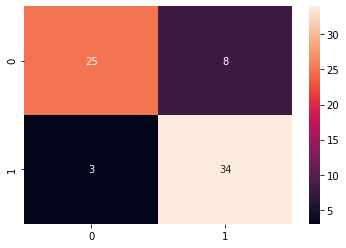

In [236]:
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True)

## Redes neuronales convolucionales

In [229]:
filters = 250
kernel_size = 3
hidden_dims = 250
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Dropout(0.2))

model.add(Conv1D(filters,
                kernel_size,
                padding='valid'
                ))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                5,
                padding='valid',
                activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 120, 16)           160000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 118, 250)          12250     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 59, 250)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 55, 250)           312750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 250)             

In [230]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size=32
epochs=5
model.fit(x_train,y_train,
         batch_size=batch_size,
         epochs=5,
         validation_data=(x_test,y_test))

Epoch 1/5
13/13 [==============================] - 2s 95ms/step - loss: 0.6925 - accuracy: 0.5700 - val_loss: 0.6866 - val_accuracy: 0.6000
Epoch 2/5
13/13 [==============================] - 1s 76ms/step - loss: 0.6864 - accuracy: 0.5638 - val_loss: 0.6697 - val_accuracy: 0.6000
Epoch 3/5
13/13 [==============================] - 1s 76ms/step - loss: 0.6568 - accuracy: 0.5571 - val_loss: 0.5664 - val_accuracy: 0.6714
Epoch 4/5
13/13 [==============================] - 1s 77ms/step - loss: 0.5044 - accuracy: 0.7466 - val_loss: 0.3819 - val_accuracy: 0.8143
Epoch 5/5
13/13 [==============================] - 1s 74ms/step - loss: 0.2008 - accuracy: 0.9396 - val_loss: 0.3734 - val_accuracy: 0.8429


In [231]:
y_pred = np.zeros(x_test.shape[0])
for i in range(x_test.shape[0]):
    if model.predict(x_test)[i][0]>0.5:
        y_pred[i]= 1
    else:
        y_pred[i]=0

<AxesSubplot:>

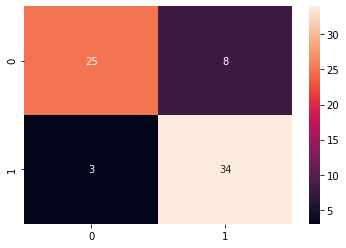

In [237]:
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True)